# Natural language processing on primary studies selected from meta-analyses
This notebook explore natural language processing (NLP) techniques on the corpus of primary studies selected in the [review of meta-analyses](https://github.com/climasoma/review-of-meta-analyses). It will explore:
- topic modelling
- relationship extraction

NOTE: this notebook needs the full-text papers to run. For copyright reasons, these are not provided with the notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import pandas as pd
import time
import os
import shutil
import re
from tqdm import tqdm
from lxml import etree, html
import requests
import requests_cache
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy import displacy
import json
from pprint import pprint
import networkx as nx # drawing network graph
import unicodedata
from io import StringIO
from scipy import stats
import copy
nlp = spacy.load("en_core_web_sm")
import warnings
warnings.simplefilter('ignore')

datadir = '../data/from-meta/'
outputdir = datadir + '../../figures/'

dfscore = pd.DataFrame(dict(zip(['step', 'n', 'recall', 'precision', 'f1', 'match'], [[]]*6)))

def camelCase(x):
    return x.lower()[0] + x.title().replace(' ','')[1:]

In [2]:
# gensim imports
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import Phrases
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim import similarities
from gensim.test.utils import datapath
import pyLDAvis
from pyLDAvis import gensim_models as gensimvis

C:\Users\gblanchy\WPy64-31050\python-3.10.5.amd64\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [3]:
print('spacy', spacy.__version__)
print('gensim', gensim.__version__)
print('nltk', nltk.__version__)
print('pyLDAvis', pyLDAvis.__version__)

spacy 3.2.4
gensim 4.2.0
nltk 3.7
pyLDAvis 3.3.1


## Preparing publications

In [4]:
# some statistics (start here)
dfpub = pd.read_csv(datadir + 'fromMeta.csv')
print('total entries:', dfpub.shape[0])
print('with doi:', dfpub['DOI'].notnull().sum())
print('retrieved:', dfpub['retrieved'].sum())
# we will only work with the ones which have full-text
dfpub = dfpub[dfpub['retrieved']].reset_index(drop=True)

total entries: 1964
with doi: 1964
retrieved: 1469


In [5]:
# creating rawdocs and extract text
rawdocs = []
c = 0
for fname in dfpub['fname']:
    # convert to text (only need to do it once)
    #os.system('pdftotext "' + datadir + 'papers/' + fname + '.pdf"')
    fpath = datadir + 'papers/' + fname + '.txt'
    if os.path.exists(fpath):
        with open(fpath, 'r', encoding='utf8') as f:
            try:
                text = f.read()
                if len(text) > 100:
                    rawdocs.append(text)
                else:
                    print('document too small', fname)
                c += 1
            except:
                print('error with', fname)
                rawdocs.append('')
    else:
        print('path not found for', fname, fpath) # pdf are empty
        rawdocs.append('')
print('imported:', c, '/', dfpub.shape[0])

imported: 1469 / 1469


### Detecting abstract, references sections

Abstract is detected based on rules (specific keywords identfied, paragraph identified). The references section is also identified. Both abstract and references are removed from the main document, `rawdocs` is overwritten.

In [6]:
# detect abstract, keywords, reference, title - overwrite rawdocs!
abstracts = []
rawdocs = []
df = pd.DataFrame(columns=['fname', 'start', 'end', 'length', 'code'])
dfpub['abstract'] = pd.NA
for i, fname in tqdm(enumerate(dfpub.loc[:, 'fname']), total=dfpub.shape[0]):
    fpath = datadir + 'papers/' + str(fname) + '.txt'
    code = ''  # determine how the abstract was found
    if (pd.isna(fname) is False) & (os.path.exists(fpath)):
        with open(fpath, 'r', encoding='utf8') as f:
            doc = f.read()
        splitdoc = re.split('a b s t r a c t|abstract|ABSTRACT|Abstract|A B S T R A C T|Summary|s u m m a r y|SUMMARY', doc)
        foundStart = True
        if len(splitdoc) == 1:
            foundStart = False
        if len(' '.join(splitdoc[1:])) > 50:
            text = '\n'.join(splitdoc[1:]) if len(splitdoc) > 1 else splitdoc[0] # if not keyword abstract found, take all
        else:
            #print('take it all for', fname)
            text = doc

        # assuming first paragraph is the abstract
        splitEnd = re.split('Published|Introduction|Copyright|©|Keywords|keywords|KEYWORDS|KEY WORDS|Citation', text)
        foundEnd = True
        if len(splitEnd) == 1:
            foundEnd = False
            #print('abstract end not found', fname)
            paragraphs = text.split('\n\n')
            ps = []
            a = ''
            # we only want paragraphs split that are more than 10 characters
            for p in paragraphs:
                a = a + '\n\n' + p
                if len(a) > 10:
                    ps.append(a)
                    a = ''
            if foundStart is True:
                abstract = ps[0]
                code = 'ps[0]'
            else:
                # without detection of the start or end, we
                # blindly assume that abstract is first paragraph
                abstract = ps[1]
                code = 'first'
                #print('abstract = first paragraph', fname)
        else:
            abstract = ''
            for j, s in enumerate(splitEnd):
                if len(s) > 50 and abstract == '':
                    abstract = s
                    code = 's{:d}'.format(j)

        # cleaning up the abstract
        if abstract[0] in [':', '.']:
            abstract = abstract[1:]
        abstract = abstract.strip()

        # edge case (if we have two first large paragraphs)
        ts = abstract.split('\n\n')
        if len(ts) > 1:
            if (len(ts[0]) > 800) & (len(ts[1]) > 800):
                if ts[0][0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
                    abstract = ts[0]
                    #print(fname, 'first')
                    code = 'ts[0]'
                else:
                    abstract = ts[1]
                    #print(fname, 'second')
                    code = 'ts[1]'

        # write down abstract for manual assessment
        with open(fpath.replace('.txt', '-abstract.txt'), 'w', encoding='utf8') as f:
            f.write(abstract)
        df = df.append({'fname': fname, 'start': foundStart, 'end': 
                        foundEnd, 'length': len(abstract), 'code': code},
                       ignore_index=True)

        # add the abstract to dfpub
        dfpub.loc[i, 'abstract'] = abstract

        # remove the abstract from the body
        body = text.replace(abstract, '')

        # remove the references
        #if len(re.findall('r(é|e)f(é|e)rences?|r ?e ?f ?e ?r ?e ?n ?c ?e ?s?', body, flags=re.IGNORECASE)) == 0:
        #    print('no ref found for', fname)
        parts = re.split('\n[ ]?r(é|e)f(é|e)rences?\n|\n[ ]?r ?e ?f ?e ?r ?e ?n ?c ?e ?s?\n', body, flags=re.IGNORECASE)
        if len(parts) > 2:  # at least one 'reference' found
            body = '\nReferences\n'.join([a for a in parts[:-1] if a is not None])
        else:
            body = body
            #print('ref not found for', dfpub.loc[i, 'fname'])
            # for old papers with no ref section parsed to OCR, that's often the case
        # failsafe for badly detected abstract
        ratio = len(body) / len(text)
        if ratio < 0.6:
            #print('abstract probably not well detected for', fname, '(ratio: {:.2f})'.format(ratio))
            body = text
        rawdocs.append(body)
    else:
        print(fpath, 'not found')
print('number of abstract detected:', dfpub['abstract'].notnull().sum(), '/', dfpub.shape[0])

100%|█████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:05<00:00, 257.69it/s]

number of abstract detected: 1469 / 1469


### Parsing abstract from webpages
This approach is a bit more reliable than the pdf to text conversion because most of the strange symbols are kept in. Also when the pdf has two or more columns, it can happen that the abstract is not the first paragraph but rather the second.

In [7]:
# getting html page (run this once)
# from selenium import webdriver
# driver = webdriver.Firefox()
# for i in tqdm(range(0, dfpub.shape[0])):
#     doi = dfpub.loc[i, 'DOI']
#     fname = dfpub.loc[i, 'fname']
#     if (pd.isna(fname) is False) & (pd.isna(doi) is False):
#         # open each doi in a new tab
#         #webbrowser.open('https://doi.org/' + doi.strip())
#         # requests is not enough to get proper rediction, better use selenium
#         driver.get('http://doi.org/' + doi)
#         time.sleep(2)  # wait a bit for the page to be fully loaded
#         with open(datadir + 'webpages/' + fname + '.html', 'w', encoding='utf8') as f:
#             f.write(driver.page_source)
# driver.close()

In [8]:
# parsing html publication to extract abstract
abstracts = []
for i in tqdm(range(0, dfpub.shape[0])):
    doi = dfpub.loc[i, 'DOI']
    fname = dfpub.loc[i, 'fname']
    fpath = datadir + 'webpages/{:s}.html'.format(fname)
    if (pd.isna(fname) is False) & (pd.isna(doi) is False) & (os.path.exists(fpath)):
        #print(i, fname, 'https://doi.org/' + doi, end='')
        with open(fpath, 'r', encoding='utf8') as f:
            tree = html.parse(StringIO(f.read()))

        try:
            # parsing abstract
            htitle = tree.xpath("//h1[text()='Abstract'] | "
                                "//h2[text()='Abstract'] | "
                                "//h3[text()='Abstract'] | "
                                "//h4[text()='Abstract'] | "
                                "//h1[text()='ABSTRACT'] | "
                                "//h2[text()='ABSTRACT'] | "
                                "//h3[text()='ABSTRACT'] | "
                                "//h4[text()='ABSTRACT'] | "
                                "//h1[text()='Summary'] | "
                                "//h2[text()='Summary'] | "
                                "//h3[text()='Summary'] | "
                                "//h4[text()='Summary'] | "
                                "//h1[text()='Abstracts'] | "
                                "//h2[text()='Abstracts'] | "
                                "//h3[text()='Abstracts'] | "
                                "//h4[text()='Abstracts'] | "
                                "//strong[text()='Abstract.']"
                               )
            parent = None
            if len(htitle) > 0:
                parent = htitle[0].getparent()
                #print(' -> found', parent.tag)
            else:
                # try to find the p or div with the longest text
                c = 0
                for p in tree.xpath('//p'):
                    # detect only the text at first level, not nested
                    pt = ' '.join(p.xpath('.//text()[normalize-space()]'))
                    if len(pt) > c:
                        parent = p
                        c = len(pt)

                # the following is matching too many div
                for div in tree.xpath('//div'):
                    divt = ' '.join(div.xpath('./text()[normalize-space()]'))
                    if len(divt) > c and len(divt) < 2000:
                        parent = div
                        c = len(divt)
                #print(' -> inferred', parent.tag)#, parent, parent.attrib, c)

            xpath = './/text() | .//div/text() | .//div/p/text() | .//p/text() |' \
                    './/div/i/text() | .//div/p/i/text() | .//p/i/text() |' \
                    './/div/b/text() | .//div/p/b/text() | .//p/b/text() |' \
                    './/div/sup/text() | .//div/p/sup/text() | .//p/sup/text() |' \
                    './/div/sub/text() | .//div/p/sub/text() | .//p/sub/text() |' \
                    './/div/emph/text() | .//div/p/emph/text() | .//p/emph/text() |' \
                    './/div/span/text() | .//div/p/span/text() | .//p/span/text() |' \
                    './/div/span/span/text() | .//div/p/span/span/text() | .//p/span/span/text() |' \
                    './/div/span/span/span/text() | .//div/p/span/span/span/text() | .//p/span/span/span/text() |' \
                    './/div/span/span/a/text() | .//div/p/span/span/a/text() | .//p/span/span/a/text() |' \
                    './/div/span/a/text() | .//div/p/span/a/text() | .//p/span/a/text() |' \
                    './/div/em/text() | .//div/p/em/text() | .//p/em/text()'

            if parent is not None:
                #print(parent, parent.attrib)
                elms = parent.xpath(xpath)
                if len(' '.join(elms)) < 100:
                    gparent = parent.getparent()
                    #print('going for grandparents', gparent, gparent.attrib)
                    #print([(a, a.attrib) for a in gparent.xpath('.//div')])
                    elms = gparent.xpath('.//div')[1].xpath(xpath)
                abstract = ' '.join(elms)
            else:
                # try to find the p or div with the longest text
                abstract = ''
                for p in tree.xpath('//p'):
                    if len(p) > len(abstract):
                        abstract = p
                for div in tree.xpath('//div'):
                    if len(div) > len(abstract):
                        print(div.getparent())
                        abstract = div
                if abstract == '':
                    #print(' -> not found')
                    pass
                else:
                    pass
                    #print(' -> long p found')

            # cleaning up
            abstract = abstract.strip()
            abstract = re.sub('Abstracts?[.]?[ \n\t]+', '', abstract)
            abstract = re.sub('ABSTRACTS?[.]?[ \n\t]+', '', abstract)
            abstract = re.sub('Summary[.]?[ \n\t]+', '', abstract)
            abstract = abstract.split('Keywords')[0]
            abstract = abstract.split('Key words')[0]
            abstract = abstract.split('Copyright')[0]
            abstract = abstract.split('©')[0]
            if len(re.split('\n[ ]+\n', abstract)) < 3:
                a = re.split('\n[ ]+\n', abstract)[0]
                if len(a) > 200:
                    abstract = a
            abstract = re.sub('[ \t\n]{2,}', '', abstract)
            abstract = abstract.strip()
            abstract = unicodedata.normalize("NFKD", abstract)
            #print('\n' + abstract + '\n')

            abstracts.append(abstract)
            dfpub.loc[i, 'abstract-web'] = abstract

        except Exception as e:
            print('-> FAILED with error' + str(e))

print('{:d}/{:d} abstracts found'.format(dfpub['abstract-web'].notnull().sum(), dfpub.shape[0]))

 77%|███████████████████████████████████████████████████████████▉                  | 1128/1469 [00:12<00:06, 49.43it/s]

-> FAILED with errorlist index out of range
-> FAILED with errorlist index out of range


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1448/1469 [00:17<00:00, 78.69it/s]

-> FAILED with errorlist index out of range
-> FAILED with errorlist index out of range


100%|██████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:17<00:00, 83.49it/s]

1465/1469 abstracts found


## Topic classifcations with `gensim`

useful links:
- LDAvis paper https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
- https://nlpforhackers.io/topic-modeling/

Coherence used is C$_V$ coherence of [Röder et al. (2015)](https://doi.org/10.1145/2684822.2685324).

In [9]:
# Tokenize the documents.
docs = []
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for doc in rawdocs:
    docs.append(tokenizer.tokenize(doc.lower()))

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only 3 characters.
docs = [[token for token in doc if len(token) > 3] for doc in docs]

# Remove Stop Words
stop_words = stopwords.words('english')
docs = [[word for word in doc if word not in stop_words] for doc in docs]

# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
# if 'soil' is followed by 'moisture' more than 20 times 'soil moisture' will be a bigram
bigram = Phrases(docs, min_count=20) 
docs2 = []
for idx in range(len(docs)):
    tmp = []
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            tmp.append(token)
    docs2.append(tmp)

# overwrite or complete docs with docs2
#docs += docs2  # add them to monograms
docs = docs2  # overwrite to only have bigrams

# filter unrelevant words

# reate a dictionary representation of the documents.
dictionary = Dictionary(docs)

# filter out words that occur in less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# bag-of-words (bow) representation of the documents
# e.g. this word appears 5 times in the first document
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: {:d}'.format(len(dictionary)))
print('Number of documents: {:d}'.format(len(corpus)))

Number of unique tokens: 2363
Number of documents: 1469


In [10]:
# Train LDA model (Latent Dirichlet Analysis)

num_topics = 6

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# create the model
model = LdaModel(
    #workers=4,
    corpus=corpus,
    id2word=dictionary,
    #chunksize=1000,
    #alpha='auto',
    #eta='auto',
    #iterations=100,
    num_topics=num_topics,
    #passes=10,
    #eval_every=None  # don't evaluate model perplexity, takes too much time.
)

# train the model with the selected coherence metrics and keep the top N words
t0 = time.time()
#top_topics = model.top_topics(corpus, coherence='u_mass', topn=5)
top_topics = model.top_topics(texts=docs, coherence='c_v', dictionary=dictionary, topn=6)
print('elapsed: {:.2f}s'.format(time.time() - t0))

# average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

# probability of a word belonging to a topic
# model.get_term_topics('cover_crop')

# bow_list =['cover_crop', 'water_content']
# # convert to bag of words format first
# bow = model.id2word.doc2bow(bow_list)

# # interpreting the data
# doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics = True)

pprint(top_topics)

elapsed: 12.49s
Average topic coherence: 0.4397.
[([(0.029608838, 'cover_crop'),
   (0.02015307, 'conventional_tillage'),
   (0.01493901, 'microbial_biomass'),
   (0.013026404, 'grain_yield'),
   (0.011451043, 'crop_residue'),
   (0.011372879, 'crop_rotation')],
  0.5182378265540617),
 ([(0.025219297, 'crop_residue'),
   (0.01052359, 'cropping_system'),
   (0.010483161, 'infiltration_rate'),
   (0.0096594775, 'water_content'),
   (0.009491419, 'conventional_tillage'),
   (0.008503506, 'crop_rotation')],
  0.5140782157997293),
 ([(0.019230725, 'cropping_system'),
   (0.010534652, 'meta_analysis'),
   (0.010519893, 'crop_residue'),
   (0.009203349, 'water_content'),
   (0.007970276, 'conventional_tillage'),
   (0.0077447216, 'grain_yield')],
  0.4493430207972482),
 ([(0.02677782, 'cover_crop'),
   (0.014459534, 'growing_season'),
   (0.012957366, 'infiltration_rate'),
   (0.010265063, 'water_content'),
   (0.009886374, 'cropping_system'),
   (0.008794981, 'crop_residue')],
  0.4411602946

In [11]:
# try multiple number of topics
avgcoh = []
models = []
modcoh = []
for num_topics in tqdm([2, 3, 4, 5, 6, 7, 8, 10, 15, 20]):
    model = LdaMulticore(
        workers=12,
        corpus=corpus,
        id2word=id2word,
        chunksize=1000,
        #alpha='auto',
        eta='auto',
        iterations=100,
        num_topics=num_topics,
        passes=10,
        eval_every=None,  # don't evaluate model perplexity, takes too much time
        random_state=7,  # for reproducibility (7 is good) 30
    )
    # topn is the number of top words to be extracted from each topic
    top_topics = model.top_topics(texts=docs, coherence='c_v', dictionary=dictionary, topn=6)
    coherences = [t[1] for t in top_topics]
    avgcoh.append([num_topics,
                   np.mean(coherences),
                   np.std(coherences)/np.sqrt(len(coherences))])
    cm = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
    modcoh.append([num_topics, cm.get_coherence()])
    models.append(copy.deepcopy(model))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:51<00:00, 47.14s/it]


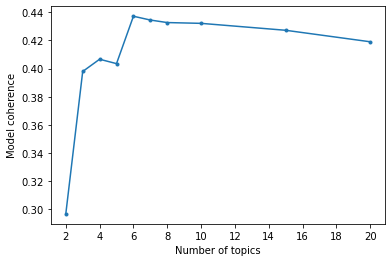

In [12]:
# figure of coherence of the model
modcoh = np.array(modcoh)
fig, ax = plt.subplots()
ax.plot(modcoh[:, 0], modcoh[:, 1], '.-')
ax.set_xlabel('Number of topics')
ax.set_ylabel('Model coherence')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.savefig(outputdir + 'coherence-meta-model.png', dpi=300)

In [17]:
# select best model or load it from disk
model = copy.deepcopy(models[np.argmax(modcoh[:, 1])])
#model.save('lda_model')
model = LdaModel.load('lda_model')

In [18]:
model.print_topics()

[(0,
  '0.033*"cropping_system" + 0.030*"conventional_tillage" + 0.018*"conservation_tillage" + 0.018*"winter_wheat" + 0.016*"crop_rotation" + 0.016*"grain_yield" + 0.015*"growing_season" + 0.012*"crop_residue" + 0.012*"water_content" + 0.010*"significant_difference"'),
 (1,
  '0.018*"infiltration_rate" + 0.013*"rainfall_event" + 0.011*"vegetation_cover" + 0.010*"grazing_intensity" + 0.010*"stocking_rate" + 0.009*"rainfall_intensity" + 0.009*"conventional_tillage" + 0.009*"ground_cover" + 0.008*"runoff_sediment" + 0.008*"significant_difference"'),
 (2,
  '0.219*"cover_crop" + 0.021*"hairy_vetch" + 0.018*"winter_cover" + 0.012*"aboveground_biomass" + 0.011*"weed_control" + 0.010*"growing_season" + 0.010*"cropping_system" + 0.008*"sampling_date" + 0.007*"microbial_biomass" + 0.006*"management_practice"'),
 (3,
  '0.036*"crop_residue" + 0.019*"crop_rotation" + 0.015*"grain_yield" + 0.013*"organic_farming" + 0.012*"management_practice" + 0.011*"farming_system" + 0.010*"conventional_tillage

In [19]:
# show interactive vizualisation
#pyLDAvis.enable_notebook()  # comment to show the interactive in the notebook
pyLDAvis.disable_notebook()
# https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=
out = gensimvis.prepare(model, corpus, dictionary)
out

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.112124 -0.071356       1        1  22.902208
0     -0.013799 -0.020501       2        1  22.465558
3      0.038543 -0.045232       3        1  15.863524
5      0.045712 -0.006820       4        1  13.510025
1      0.013720  0.181042       5        1  13.314760
2     -0.196300 -0.037132       6        1  11.943925, topic_info=                        Term         Freq        Total Category  logprob  \
289               cover_crop  9700.000000  9700.000000  Default  30.0000   
61             water_content  4550.000000  4550.000000  Default  29.0000   
417          water_retention  2245.000000  2245.000000  Default  28.0000   
92              crop_residue  3765.000000  3765.000000  Default  27.0000   
1582             hairy_vetch   913.000000   913.000000  Default  26.0000   
...                      ...          ...          ...      ...      

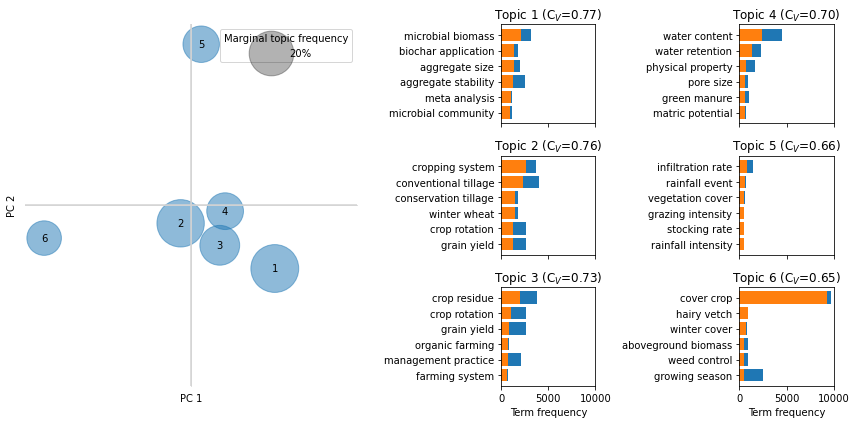

In [20]:
# figure similar to Padarian and LDAvis
fig = plt.figure(figsize=(12, 6))

# topic on pca axes
df = out.topic_coordinates
num_topics = df.shape[0]
ax = plt.subplot2grid((num_topics//2, 4), (0, 0), rowspan=num_topics//2, colspan=2)
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.set_xticks([])
ax.set_yticks([])
ax.axhline(0, color='lightgrey')
ax.axvline(0, color='lightgrey')
scatter = ax.scatter(df['x'], df['y'], s=df['Freq']*100, alpha=0.5)
for i in range(df.shape[0]):
    ax.text(df.loc[i, 'x'], df.loc[i, 'y'], str(df.loc[i, 'topics']), ha='center', va='center')
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", num=1, alpha=0.3, fmt='{x:.0f}%', func=lambda x: x/100)
legend2 = ax.legend(handles, labels, title="Marginal topic frequency")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
xmax = np.abs(ax.get_xlim()).max()
ymax = np.abs(ax.get_ylim()).max()
a = 0.05  # 5% padding
ax.set_xlim([-xmax-a*xmax, xmax+a*xmax])
ax.set_ylim([-ymax-a*ymax, ymax+a*ymax])

# terms frequency in topic (bar plot)
df = out.topic_info
nrows = num_topics//2
topn = 6  # number of terms to show in bar plot
xlim = [0, 10000]
for i in range(num_topics):  # we don't care about 'Default' topic
    category = 'Topic' + str(i+1)
    tdf = df[df['Category'].eq(category)].sort_values('Freq', ascending=False).reset_index(drop=False)
    ax = plt.subplot2grid((nrows, 4), (i % nrows, 2 + i // nrows))
    ax.set_title('Topic {:d} (C$_V$={:.2f})'.format(i+1, top_topics[i][1]))
    ax.barh(np.arange(topn), tdf['Total'].values[:topn])
    ax.barh(np.arange(topn), tdf['Freq'].values[:topn])
    terms = tdf['Term'].str.replace('_', ' ').values[:topn].tolist()
    ax.set_yticks(np.arange(len(terms)))
    ax.set_yticklabels(terms)
    ax.set_xlim(xlim)
    ax.invert_yaxis()
    if (i+1) % nrows == 0:
        ax.set_xlabel('Term frequency')
    else:
        ax.set_xticklabels([])
fig.tight_layout()
fig.savefig(outputdir + 'topics-meta.png', dpi=300)

## Detecting relationships

By looking at sentence that contains a 'driver' and a 'property', we try to find the relationship between the two.

### Replacing abbreviation and detecting coreference
Coreference consists in replace a pronoun with the entity it is refering to. In the case observed in the abstract, we did not found it to be useful.

In [92]:
# replace abbreviation
def replaceAbbreviation(text):
    if pd.isna(text) is False:
        abrvs = [a for a in re.findall(r'(\([A-Z]*\))', text) if len(a) > 3]
        for abrv in abrvs:
            meaning = ' '.join(re.split(' |\\n', text.split(abrv)[0])[-(len(abrv)-1):])
            text = text.replace(abrv, '')
            text = text.replace(abrv[1:-1], meaning)
    return text


replaceAbbreviation('the soil organic carbon (SOC) is generally well used. SOC is dependent on ')
dfpub['abstract'] = dfpub['abstract'].apply(replaceAbbreviation)
dfpub['abstract-web'] = dfpub['abstract-web'].apply(replaceAbbreviation)

In [93]:
# replacing et al. by et al (without dots) to prevent it being as sentence period
def replaceEtAl(text):
    if pd.isna(text) is False:
        return text.replace('et al.', 'et al')
dfpub['abstract'] = dfpub['abstract'].apply(replaceEtAl)
dfpub['abstract-web'] = dfpub['abstract-web'].apply(replaceEtAl)

### Example

In [94]:
# example for paper
text = "In the short term, tillage operations significantly increased K"# for the entire range of pressure head applied."
sent = nlp(text)
displacy.render(sent, style='dep', options={'compact': True, 'distance': 90})

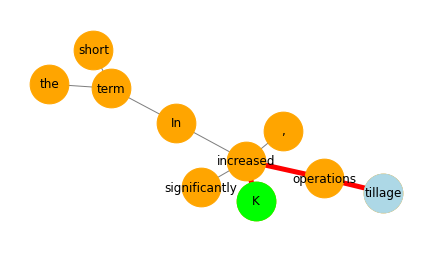

In [95]:
# build dependency graph and show shortest dependency path
fig, ax = plt.subplots()
node_size = 1500

# find shortest dependency path (SDP)
edges = []
for token in sent:
    for child in token.children:
        edges.append((token.i, child.i))
G = nx.Graph(edges)
sdp = nx.shortest_path(G, 
                       source=5,
                       target=9)

# draw network
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
nx.draw_networkx_nodes(G, pos, alpha=1, ax=ax, node_color='orange', node_size=node_size)
nx.draw_networkx_labels(G, pos, labels=dict(zip(np.arange(len(sent)), [a for a in sent])),
                        font_family="sans-serif", ax=ax, font_size=12)

# draw sdp
path_edges = list(zip(sdp, sdp[1:]))
nx.draw_networkx_nodes(G, pos, nodelist=sdp[:1], node_color='lightblue', node_size=node_size)
nx.draw_networkx_nodes(G, pos, nodelist=sdp[-1:], node_color='lime', node_size=node_size)
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=5)

plt.axis("off")
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
fig.tight_layout()
fig.savefig(outputdir + 'sdp.png', dpi=300)

### Identifying relevant sentences
Namely, a sentence which contains a relationships between a 'driver' and a 'property'.

In [96]:
# identify drivers and practices (could make this more complex by using the mural's keywords)
drivers = ['tillage', 'cover crop', 'catch crop', 'residue', 'fertilizer', 'manure', 'liming', 
           'compost', 'traffic', 'compaction', 'biochar', 'irrigation', 'intercropping', 'agroforestry']
variables = [
    'hydraulic conductivity', 'water retention', 'available water', 'runoff',
    'infiltration', 'bulk density', 'macroporosity', 'penetration resistance',
    'soil strength', 'aggregate stability', 'aggregation', 'yield', 'organic matter',
    'organic carbon', 'microbial activity', 'microbial biomass', 'faunal activity',
    'faunal biomass', 'earthworm biomass', 'earthworm activity', 'root biomass',
    'root depth', 'root growth',
    # below are added from abstracts (so in in original search query)
    'rainwater penetration', 'K', 'Ks', 'K(h)', 'K0', 'infiltration rate' 
]

In [97]:
# building patterns
driverMatcher = PhraseMatcher(nlp.vocab, attr='LEMMA')
for driver in drivers:
    driverMatcher.add(camelCase(driver), [nlp(driver)])

variableMatcher = PhraseMatcher(nlp.vocab, attr='LEMMA')
for variable in variables:
    variableMatcher.add(camelCase(variable), [nlp(variable)])

patterns = [
    [
        {'POS': 'AUX', 'OP': '+'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ', 'OP': '*'}],
    [
        {'POS': 'VERB', 'OP': '+'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ', 'OP': '?'},
        {'POS': 'NOUN', 'OP': '?'}],
]
verbMatcher = Matcher(nlp.vocab)
verbMatcher.add('be have', patterns)

In [ ]:
# look for sentence with the two keywords
dfmatch = pd.DataFrame(columns=['pubid', 'driver', 'variable', 'sentence',
                                'driverChunk', 'driverVerb', 'variableChunk',
                                'variableVerb', 'negation', 'sdp', 'relationship'])
for i, abstract in tqdm(enumerate(dfpub['abstract-web']), total=dfpub.shape[0], leave=True):
    if pd.isna(abstract) is False:
        doc = nlp(abstract)
        # looking for sentence containing driver and variable
        for sent in doc.sents:
            driverMatches = []
            variableMatches = []
            # looking inside each name chunk for keywords
            for chunk in sent.noun_chunks:
                matches = driverMatcher(chunk)
                if len(matches) > 0:
                    driverMatches.append(
                        (nlp.vocab.strings[matches[0][0]], chunk))
                matches = variableMatcher(chunk)
                if len(matches) > 0:
                    variableMatches.append(
                        (nlp.vocab.strings[matches[0][0]], chunk))
            # check if negation
            negs = [token for token in sent if token.dep_ == 'neg']
            if len(driverMatches) > 0 and len(variableMatches) > 0:
                # building relationship between drivers and variables found
                for driverMatch in driverMatches:
                    for variableMatch in variableMatches:
                        # attempting to get the verb linking the two chunk
                        # in a recursive way
                        if driverMatch[1].root.head.pos_ == 'VERB':
                            verb1 = driverMatch[1].root.head.text
                        elif driverMatch[1].root.head.head.pos_ == 'VERB':
                            verb1 = driverMatch[1].root.head.head.text
                        elif driverMatch[1].root.head.head.head.pos_ == 'VERB':
                            verb1 = driverMatch[1].root.head.head.head.text
                        elif driverMatch[1].root.head.head.head.head.pos_ == 'VERB':
                            verb1 = driverMatch[1].root.head.head.head.head.text
                        else:
                            verb2 = None
                        if variableMatch[1].root.head.pos_ == 'VERB':
                            verb2 = variableMatch[1].root.head.text
                        elif variableMatch[1].root.head.head.pos_ == 'VERB':
                            verb2 = variableMatch[1].root.head.head.text
                        elif variableMatch[1].root.head.head.head.pos_ == 'VERB':
                            verb2 = variableMatch[1].root.head.head.head.text
                        elif variableMatch[1].root.head.head.head.head.pos_ == 'VERB':
                            verb2 = variableMatch[1].root.head.head.head.head.text
                        else:
                            verb2 = None
                        # find shortest dependency path (SDP)
                        edges = []
                        for token in sent:
                            for child in token.children:
                                edges.append((token.i, child.i))
                        graph = nx.Graph(edges)
                        sdp = nx.shortest_path(graph, 
                                               source=driverMatch[1].root.i,
                                               target=variableMatch[1].root.i)
                        i2t = dict(zip([token.i for token in sent],
                                       [token for token in sent]))
                        #sdpVerb = [i2t[a].lower_ for a in sdp if i2t[a].pos_ == 'VERB']
                        
                        # replace driver, variable and verb by more informative chunks
                        sdpPath = ', '.join([i2t[a].lower_ for a in sdp])
                        sdpPath = sdpPath.replace(driverMatch[1].root.text,
                                                  driverMatch[1].text.lower())
                        sdpPath = sdpPath.replace(variableMatch[1].root.text,
                                                  variableMatch[1].text.lower())
                        verbMatches = verbMatcher(sent)
                        verbSpans = [sent[start:end] for _, start, end in verbMatches]
                        sdpVerb = ''
                        sdpVerbLong = ''
                        for a in sdp:
                            token = i2t[a]
                            if (token.pos_ == 'AUX') | (token.pos_ == 'VERB'):
                                sdpVerb = token.text
                                sdpVerbLong = token.text
                                for verbSpan in verbSpans:
                                    if ((token in verbSpan) 
                                        & (len(sdpVerbLong) < len(verbSpan.text))):
                                        sdpVerbLong = verbSpan.text
                        sdpPath = sdpPath.replace(sdpVerb, sdpVerbLong)

                        dic = {
                            'pubid': i,
                            'driver': driverMatch[0],
                            'variable': variableMatch[0],
                            'sentence': sent.text.strip().replace('\n',' '),
                            'driverChunk': driverMatch[1].text.strip().replace('\n', ' '),
                            'driverVerb': verb1,
                            'variableChunk': variableMatch[1].text.strip().replace('\n', ' '),
                            'variableVerb': verb2,
                            'sdp': sdpPath,
                            #'sdp_old': ', '.join([i2t[a].lower_ for a in sdp]),
                            'sdpVerb': sdpVerbLong,
                            'negation': True if len(negs) % 2 != 0 else False,
                        }
                        dfmatch = dfmatch.append(dic, ignore_index=True)
# drop duplicates
print(dfmatch.shape, '-> ', end='')
dfmatch = dfmatch.drop_duplicates().reset_index(drop=True)
print(dfmatch.shape, 'after duplicates drop')

print('{:d} relationship detected (among {:d} documents)'.format(
    dfmatch.shape[0], dfpub.shape[0]))
dfmatch.sort_values('sentence').to_excel(datadir + 'dfmatch-web.xlsx', index=False)

### Assessing the correlation of relationships
Possible sentiments:
- +1: the two entities are positively correlated, when the driver increases, the property increases (e.g. biochar incrases hydraulic conductivity)
- -1: the two entities are negativaly correlated, when the driver increases, the property decreases (e.g. reduced tillage increase soil hydraulic conductivity)
- 0: there is not effect, neither positive or negative (e.g. the application of biochar had no significant effect on soil hydraulic conductivity)
- 2: has been studied but no conclusion (e.g. the effect of biochar on soil hydraulic conductivity were investigated)
- NA: not relevant, unclassified

In [99]:
# load dataframe with manually assessed sentence
dfmatch = pd.read_excel(datadir + 'dfmatch-web-labels.xlsx')

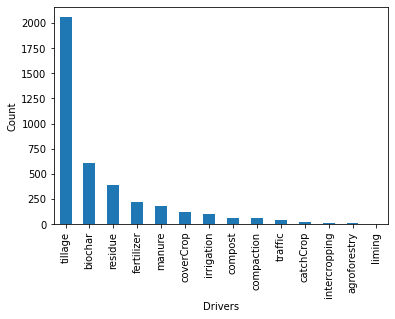

In [100]:
# drivers and predictors
fig, ax = plt.subplots()
dfmatch['driver'].value_counts().plot(kind='bar', ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Drivers');

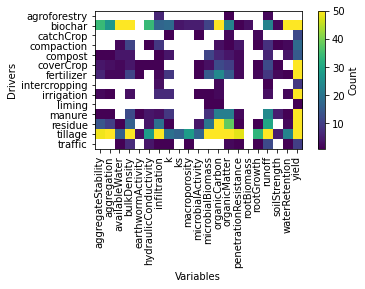

In [108]:
# show number of sentences identified
dft = dfmatch[['driver', 'variable']].copy()
dft['one'] = 1
dft = dft.pivot_table(values='one', columns='driver', index='variable', aggfunc=np.sum, fill_value=0)
dft = dft.replace(0, np.nan)
fig, ax = plt.subplots()
cax = ax.imshow(dft.values.T, vmax=50)
ax.set_yticks(np.arange(dft.shape[1]))
ax.set_yticklabels(dft.columns)
ax.set_ylabel('Drivers')
ax.set_xticks(np.arange(dft.shape[0]))
ax.set_xticklabels(dft.index, rotation=90)
ax.set_xlabel('Variables')
fig.colorbar(cax, ax=ax, label='Count')
fig.subplots_adjust(bottom=0.2)
fig.tight_layout()
fig.savefig(outputdir + 'rel-identified-meta.png', dpi=300)

In [102]:
# matcher for sentiments
posVerb = ['enhance', 'increase', 'improve', 'mitigate',
           'have significant increase', 'have significant effect',
           'have greater effect', 'be higher', 'can make a valuable contribution']
negVerb = ['decrease', 'reduce', 'prevent', 'be lower', 
           'have significant decrease']
neuVerb = ['have no effect', 'have no signficant effect', 'have minimal effect', 
           'be relatively small', 'whatever', 'affect']
posMatcher = PhraseMatcher(nlp.vocab, attr='LEMMA')
for a in posVerb:
    posMatcher.add(camelCase(a), [nlp(a)])
negMatcher = PhraseMatcher(nlp.vocab, attr='LEMMA')
for a in negVerb:
    negMatcher.add(camelCase(a), [nlp(a)])
neuMatcher = PhraseMatcher(nlp.vocab, attr='LEMMA')
for a in neuVerb:
    neuMatcher.add(camelCase(a), [nlp(a)])

studyWords = ['study', 'analyzed', 'analysed', 'measured', 'hypothesize', 'determine',
              'assessed', 'reported', 'be done', 'be conducted', 'quantify', 'compare']
studyMatcher = PhraseMatcher(nlp.vocab, attr='LEMMA')
studyMatcher.add('study', [nlp(a) for a in studyWords])
studyWords2 = ['objective', 'purpose', 'study']
studyMatcher2 = PhraseMatcher(nlp.vocab, attr='LEMMA')
studyMatcher2.add('study', [nlp(a) for a in studyWords2])

# was higher (be + modifiers), had a greater effect
# had higher hydraulic conductivity, lower, decreasing of, improvement in

In [103]:
# assessing sentiment on shortest dependency path (sdp)
dfmatch['sdpRel'] = np.nan
modifiers = ['less', 'conservation', 'no-', 'no', '(non-inversion)', 'non-inversion',
             'reduced', 'minimum', 'decreasing of', 'decreasing in']
for i, sdp in tqdm(enumerate(dfmatch['sdp']), total=dfmatch.shape[0]):
    # identify modifier
    a = 1
    driverChunk = dfmatch.loc[i, 'driverChunk']
    if pd.Series(driverChunk.split(' ')).isin(modifiers).sum() > 0:
        a = -1
    b = 1
    variableChunk = dfmatch.loc[i, 'variableChunk']
    if pd.Series(variableChunk.split(' ')).isin(modifiers).sum() > 0:
        b = -1
    c = 1
    if dfmatch.loc[i, 'negation'] == True:
        c = -1
    if len(posMatcher(nlp(sdp))) > 0:
        dfmatch.loc[i, 'sdpRel'] = 1 * a * b * c
    elif len(negMatcher(nlp(sdp))) > 0:
        dfmatch.loc[i, 'sdpRel'] = -1.0 * a * b * c
    elif len(neuMatcher(nlp(sdp))) > 0:
        dfmatch.loc[i, 'sdpRel'] = 0.0
    elif len(studyMatcher(nlp(sdp))) > 0:
        dfmatch.loc[i, 'sdpRel'] = 2.0
    else:
        # these lines below add quite a bit of relationships
        if len(studyMatcher(nlp(dfmatch.loc[i, 'sentence']))) > 0:
            dfmatch.loc[i, 'sdpRel'] = 2.0

print('{:d}/{:d} relationship found'.format(
    dfmatch['sdpRel'].notnull().sum(), dfmatch.shape[0]))
dfmatch.sort_values('sentence').to_excel(datadir + 'dfmatch-nlp.xlsx', index=False)

  0%|          | 0/3878 [00:00<?, ?it/s]

2254/3878 relationship found


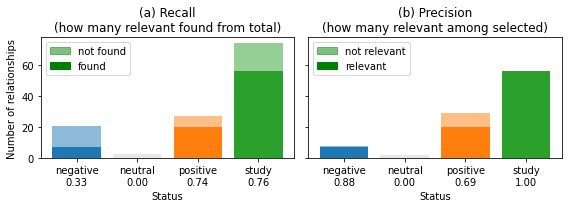

In [104]:
# figure (double histogram with well identified and not well identified)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
cats = [-1, 0, 1, 2]
colors = {1: 'tab:orange', 0: 'lightgrey', -1: 'tab:blue', 2: 'tab:green'}
xlabs = ['negative', 'neutral', 'positive', 'study']
isub = dfmatch['relTrue'].isin(cats)

# recall
ax = axs[0]
ax.set_title('(a) Recall\n(how many relevant found from total)')
#ie = dfmatch['relationship'].isna() & dfmatch['relTrue'].isna()
#cax = ax.bar(-2, ie.sum())
#ax.bar(-2, dfmatch['relTrue'].isna().sum(), bottom=ie.sum(),
#       alpha=0.5, color=cax.patches[0].get_facecolor())
scores = []
for cat in cats:
    icommon = dfmatch[isub]['sdpRel'].eq(cat) & dfmatch[isub]['relTrue'].eq(cat)
    irelevant = dfmatch[isub]['relTrue'].eq(cat)
    scores.append(icommon.sum()/irelevant.sum())
    cax = ax.bar(cat, icommon.sum(), color=colors[cat])
    ax.bar(cat, irelevant.sum(),
           alpha=0.5, color=cax.patches[0].get_facecolor())
ax.bar([], [], color='k', alpha=0.5, label='not found')
ax.bar([], [], color='k', alpha=1, label='found')
leg = ax.legend()
for lh, a in zip(leg.legendHandles, [0.5, 1]): 
    lh.set_alpha(a)
    lh.set_color('green')
ax.set_xticks(cats)
ax.set_xticklabels([xlab + '\n{:.2f}'.format(a) for xlab, a in zip(xlabs, scores)])
ax.set_xlabel('Status')
ax.set_ylabel('Number of relationships')

ax = axs[1]
ax.set_title('(b) Precision\n(how many relevant among selected)')
#ie = dfmatch['relationship'].isna() & dfmatch['relTrue'].isna()
#cax = ax.bar(-2, ie.sum())
#ax.bar(-2, dfmatch['relTrue'].isna().sum(), bottom=ie.sum(),
#       alpha=0.5, color=cax.patches[0].get_facecolor())
scores = []
for cat in cats:
    icommon = dfmatch[isub]['sdpRel'].eq(cat) & dfmatch[isub]['relTrue'].eq(cat)
    iselected = dfmatch[isub]['sdpRel'].eq(cat)
    scores.append(icommon.sum()/iselected.sum())
    cax = ax.bar(cat, icommon.sum(), color=colors[cat])
    ax.bar(cat, iselected.sum(),
           alpha=0.5, color=cax.patches[0].get_facecolor())
ax.bar([], [], color='k', alpha=0.5, label='not relevant')
ax.bar([], [], color='k', alpha=1, label='relevant')
leg = ax.legend()
for lh, a in zip(leg.legendHandles, [0.5, 1]): 
    lh.set_alpha(a)
    lh.set_color('green')
ax.set_xticks(cats)
ax.set_xticklabels([xlab + '\n{:.2f}'.format(a) for xlab, a in zip(xlabs, scores)])
ax.set_xlabel('Status')
fig.tight_layout()
fig.savefig(outputdir + 'rel-score-bar-meta.png', dpi=500)

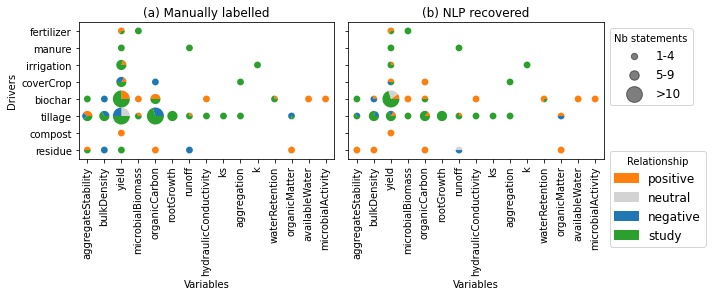

In [105]:
# figure with matrix relationship between drivers and properties

ie = dfmatch['relTrue'].notnull()  # all not NaN relationships

df = dfmatch[ie].copy().replace(-2, np.nan)
drivers = df['driver'].unique()
variables = df['variable'].unique()
colors = {1: 'tab:orange', 0: 'lightgrey', -1: 'tab:blue', 2: 'tab:green'}
r = 0.3 # could make the radius varies with the number of relationships found

# create legend (for sizes)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axs[0]
ax.set_title('(a) Manually labelled')
for i, driver in enumerate(drivers):
    for j, variable in enumerate(variables):
        ie = df['driver'].eq(driver) & df['variable'].eq(variable)
        s = df[ie]['relTrue'].value_counts()
        a = s.sum()
        sdict = (s/a).to_dict()  # in proportion
        if a < 5:
            r = 0.2
        elif a < 10:
            r = 0.3
        else:
            r = 0.5
        theta1 = 0
        for key in [1, 0, -1, 2]:
            if key in sdict:
                val = sdict[key]
                theta2 = theta1 + val*360
                ax.add_patch(mpatches.Wedge((j, i), r, theta1, theta2, ec='none',
                                            color=colors[key]))
                theta1 = theta2
ax.set_yticks(np.arange(len(drivers)))
ax.set_yticklabels(drivers)
ax.set_ylabel('Drivers')
ax.set_xticks(np.arange(len(variables)))
ax.set_xticklabels(variables, rotation=90)
ax.set_xlabel('Variables')
ax.set_aspect('equal')

ax = axs[1]
ax.set_title('(b) NLP recovered')
for i, driver in enumerate(drivers):
    for j, variable in enumerate(variables):
        ie = df['driver'].eq(driver) & df['variable'].eq(variable)
        s = df[ie]['sdpRel'].value_counts()
        a = s.sum()
        sdict = (s/a).to_dict()  # in proportion
        if a < 5:
            r = 0.2
        elif a < 10:
            r = 0.3
        else:
            r = 0.5
        theta1 = 0
        for key in [1, 0, -1, 2]:
            if key in sdict:
                val = sdict[key]
                theta2 = theta1 + val*360
                ax.add_patch(mpatches.Wedge((j, i), r, theta1, theta2, ec='none',
                                            color=colors[key]))
                theta1 = theta2
ax.set_xticks(np.arange(len(variables)))
ax.set_xticklabels(variables, rotation=90)
ax.set_xlabel('Variables')

# add legend
msizes = [0.2, 0.3, 0.5]
labels = ['1-4', '5-9', '>10']
markers = []
for i, size in enumerate(msizes):
    markers.append(plt.scatter([],[], s=size**2*1000, label=labels[i], color='k', alpha=0.5))
ax.add_artist(plt.legend(handles=markers, bbox_to_anchor=(1, 1), title='Nb statements', fontsize=12))

markers = []
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[1], label='positive')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[0], label='neutral')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[-1], label='negative')))
markers.append(ax.add_patch(mpatches.Wedge((0,0), 0, 0, 360, color=colors[2], label='study')))
ax.legend(handles=markers, bbox_to_anchor=(1, 0.1), title='Relationship', fontsize=12)

ax.set_xlim([-0.5, len(variables)-0.5])
ax.set_ylim([-0.5, len(drivers)-0.5])
ax.set_aspect('equal')

fig.tight_layout()
fig.savefig(outputdir + 'rel-bubbles-meta.png', dpi=500)

In [106]:
# scoring

# task 1: identification of relationships
# we would need to manually extract all relationship from abstract for this

# task 2: sentiment of relationships (match (+1/-1) or not (0))
#col = 'relationship'
col = 'sdpRel'
n = dfmatch.shape[0]
tp = (dfmatch[col].notnull() & dfmatch['relTrue'].notnull()).sum()
tn = (dfmatch[col].isna() & dfmatch['relTrue'].isna()).sum()
fp = (dfmatch[col].notnull() & dfmatch['relTrue'].isna()).sum()
fn = (dfmatch[col].isna() & dfmatch['relTrue'].notnull()).sum()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (recall * precision) / (recall + precision)
print('on selection of relevant relationships:')
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('f1 score: {:.2f}'.format(f1))

# task 3: correct assignement
ie = dfmatch['relTrue'].notnull() & dfmatch['relTrue'].ne(-2)
match = (dfmatch[ie][col] == dfmatch[ie]['relTrue']).sum()
print('correctly assigned: {:d}/{:d} ({:.0f}%)'.format(
    match, np.sum(ie), match/np.sum(ie)*100))

on selection of relevant relationships:
recall: 0.74
precision: 0.04
f1 score: 0.08
correctly assigned: 83/125 (66%)


In [107]:
# show mistakes
ie1 = dfmatch['relTrue'].isna() & dfmatch['sdpRel'].isna()
ie2 = dfmatch['relTrue'] != dfmatch['sdpRel']
ie2[ie1] = False  # nan != nan always true
dfmatch[ie2][['driver', 'variable', 'sentence', 'driverVerb', 'variableVerb', 'negation', 'sdp', 'sdpRel', 'relTrue']]

,driver,variable,sentence,driverVerb,variableVerb,negation,sdp,sdpRel,relTrue
0,fertilizer,organicCarbon,(3) Long-lasting application of organic amendm...,increased,increased,False,"chemical fertilizer treatments, versus, %, inc...",1.0,NaN
2,residue,bulkDensity,"(4) Regular addition of organic residues, part...",increased,decreasing,False,"organic residues, of, addition, by, improving,...",1.0,-1.0
8,tillage,bulkDensity,(non-inversion) tillage increased soil bulk d...,increased,increased,False,"conventional tillage, with, comparison, in, la...",1.0,NaN
15,biochar,microbialBiomass,-N. The application of biochar significantly i...,increased,increased,False,"biochar, of, application, increased soluble, m...",1.0,NaN
18,manure,yield,A 200 to 300% increase in wheat yields and N u...,depending,obtained,False,"green manure species, on, depending, obtained,...",1.0,NaN
...,...,...,...,...,...,...,...,...,...
3869,tillage,aggregation,"soil organic matter content, mineralization, ...",decreased,NaN,False,"tillage, of, result, as, decreased, soil, cont...",-1.0,NaN
3870,tillage,earthwormActivity,"soil organic matter content, mineralization, ...",decreased,decreased,False,"tillage, of, result, as, decreased, soil, cont...",-1.0,NaN
3873,tillage,runoff,subsoiling with mulch reduced soil loss by mo...,compared,became,False,"conventional tillage, to, compared, subsoiling...",2.0,NaN
3874,biochar,yield,the wood biochar type used in this study had n...,had,had,False,"the wood biochar type, had, impact, on, aerobi...",1.0,NaN
